In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import tyssue
import sys
sys.path.append('/home/guillaume/Python/tyssue/src/py-tyssue/')
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt

from scipy import optimize

from tyssue.core.sheet import Sheet

import tyssue.geometry.sheet_geometry as geom
import tyssue.dynamics.sheet_vertex_model as model
import tyssue.solvers.sheet_vertex_solver as solver

from tyssue.io import hdf5

In [4]:
h5store = 'small_hexagonal.hf5'
datasets = hdf5.load_datasets(h5store, data_names=['cell', 'jv', 'je'])
sheet = Sheet('emin', datasets)

# hdf5.save_datasets('small_hexagonal.hf5', sheet)

In [14]:
sheet.je_df.head()

,,,dy,dx,dz,length,old_jv0,old_jv1,old_cell,nx,ny,nz,sub_area,line_tension
srce,trgt,cell,,,,,,,,,,,,
1,0,0,-1.857558,0.369491,-1.10053,2.190482,56,57,0,1.888686,7.823193e-01,-6.863514e-01,1.078220e+00,0.12
2,1,0,-1.574762,1.052222,1.10053,2.190482,57,58,0,0.000000,-2.220446e-16,-3.330669e-16,2.001483e-16,0.12
0,1,1,1.857558,-0.369491,1.10053,2.190482,56,57,1,4.088597,5.421817e-01,4.575676e-01,2.074847e+00,0.12
3,0,1,1.857558,0.369491,-1.10053,2.190482,56,59,1,4.088597,-5.421817e-01,4.575676e-01,2.074847e+00,0.12
1,6,1,0.000000,0.000000,2.20106,2.201060,57,62,1,4.088597,2.710909e-01,0.000000e+00,2.048787e+00,0.12


In [6]:
sheet.cell_df.head()

,perimeter,z,x,is_alive,area,y,old_idx
cell,,,,,,,
0,0.00000,-8.437398e+00,4.256965,0,12.000000,1.763293e+00,0
1,13.16405,-6.603181e+00,4.607705,1,12.396962,5.921189e-16,1
2,13.16405,-3.301591e+00,4.256965,1,12.396962,1.763293e+00,2
3,13.16405,-1.480297e-16,4.607705,1,12.396962,5.921189e-16,3
4,13.16405,3.301591e+00,4.256965,1,12.396962,1.763293e+00,4


In [7]:
geom.default_params

{'basal_shift': 4.0, 'geometry': 'cylindrical', 'height_axis': 'z'}

In [16]:
geom.set_geometry_columns(sheet)
geom.update_all(sheet, coords=sheet.coords)

In [17]:
model.default_params

{'contractility': 0.04,
 'line_tension': 0.12,
 'prefered_area': 10.0,
 'prefered_height': 24.0,
 'vol_elasticity': 1.0}

In [18]:


adim_parameters = model.default_params.copy()
model_params = model.dimentionalize(model.default_params)
model.set_dynamic_columns(sheet)


we define the adimentional contractility $\bar\Gamma = \Gamma/K_vA_0h_0^2$ and line tension
$\bar\Lambda = \Lambda /K_v (A_0^{3/2}h_0^2)$, where $h_0$ is such that $V_0 = A_0h_0$.


In [20]:
sheet.cell_df['num_sides'] = np.bincount(sheet.e_cell_idx.get_level_values('cell'))

In [35]:

grad_err = check_local_grad(eptm)
grad_err / eptm.norm_factor

0.30141945113648949

In [36]:
grad_i, grad_t, grad_c, grad_v = compute_gradient(eptm, components=True)

In [37]:
grad_i.head()

,x,y,z
jv,,,
0,1073.787025,-1402.206426,-3248.661486
1,1147.056322,-1030.340882,317.449506
2,1750.791760,-232.227585,-3248.661486
3,82.530279,-1539.652328,317.449506
4,606.641676,-263.549341,784.463679


In [38]:
mu = 6 * np.sqrt(2. / (3 * np.sqrt(3)))


def isotropic_energy(adim_parameters, delta):
    """
    Computes the theoritical energy per cell for the given
    parameters.
    """
    lbda = adim_parameters['line_tension']
    gamma = adim_parameters['contractility']

    elasticity = (delta**3 - 1 )**2 / 2.
    contractility = gamma * mu**2 * delta**2 / 2.
    tension = lbda * mu * delta / 2.
    energy = elasticity + contractility + tension
    return energy

def isotropic_grad_poly(adim_parameters):

    lbda = adim_parameters['line_tension']
    gamma = adim_parameters['contractility']
    grad_poly = [3, 0, 0,
                 -3,
                 mu**2 * gamma,
                 mu * lbda / 2.]
    return grad_poly

def isotropic_grad(adim_parameters, delta):
    grad_poly = isotropic_grad_poly(adim_parameters)
    return np.polyval(grad_poly, delta)

def find_grad_roots(adim_parameters):
    
    p = isotropic_grad_poly(adim_parameters)
    roots = np.roots(p)
    good_roots = np.real([r for r in roots if np.abs(r) == r])
    np.sort(good_roots)
    if len(good_roots) == 1:
        return good_roots
    elif len(good_roots) > 1:
        return good_roots[0]
    else:
        return np.nan

def isotropic_relax(eptm):

    update_cylindrical(eptm)
    area0 = parameters['prefered_area']
    h_0 = parameters['prefered_height']

    live_cell_idx = (eptm.cell_df.is_alive==1).index
    live_cells = eptm.cell_df.loc[live_cell_idx]
    
    area_avg = live_cells.area.mean()
    rho_avg = live_cells.rho.mean()


    ### Set height and area to height0 and area0
    delta = (area0 / area_avg)**0.5
    scale(eptm, delta)
    parameters['rho_lumen'] = rho_avg * delta - h_0
    sheet_geometry.update_all(eptm)
    update_vol(eptm)
    
    ### Optimal value for delta
    delta_o = find_grad_roots(adim_parameters)
    if not np.isfinite(delta_o):
        raise ValueError('invalid parameters values')
    eptm.delta_o = delta_o
    ### Scaling

    scale(eptm, delta_o)
    sheet_geometry.update_all(eptm)
    update_vol(eptm)



In [39]:
isotropic_relax(eptm)

In [40]:
grad_i, grad_t, grad_c, grad_v = compute_gradient(eptm, components=True)

In [41]:
grad_i.head() / eptm.norm_factor

,x,y,z
jv,,,
0,0.020505,-0.018389,-0.054548
1,0.021057,-0.010822,0.000789
2,0.027502,0.001496,-0.054548
3,0.007237,-0.022542,0.000789
4,0.016077,-0.007019,0.000059


In [42]:
def elasticity(delta):
    return (delta**3 - 1 )**2 / 2.

def contractility(delta, gamma):
    return gamma * mu**2 * delta**2 / 2.

def tension(delta, lbda):
    return lbda * mu * delta / 2.

def isotropic_energy(delta, gamma, lbda):
    
    energy = (elasticity(delta)
              + contractility(delta, gamma)
              + tension(delta, lbda))
    return energy

In [43]:
live_cell_idx = (cell_df.is_alive==1).index

0.886592687387 0.783934586743


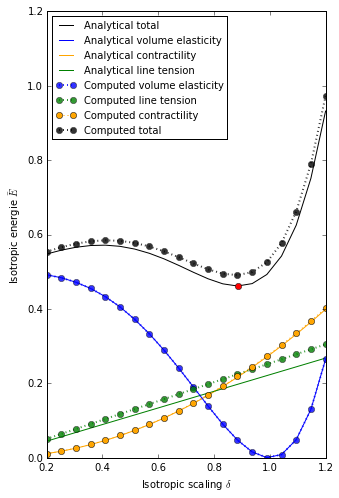

In [44]:
%matplotlib inline
deltas = np.linspace(0.2, 1.2, 20)
fig, ax = plt.subplots(figsize=(5, 8))
lbda = adim_parameters['line_tension']
gamma = adim_parameters['contractility']
ax.plot(deltas, isotropic_energy(deltas, gamma, lbda), 'k-',
        label='Analytical total')
ax.plot(eptm.delta_o, isotropic_energy(eptm.delta_o, gamma, lbda), 'ro')
ax.plot(deltas, elasticity(deltas), 'b-',
        label='Analytical volume elasticity')
ax.plot(deltas, contractility(deltas, gamma), color='orange', ls='-',
        label='Analytical contractility')
ax.plot(deltas, tension(deltas, lbda), 'g-',
        label='Analytical line tension')

ax.set_xlabel(r'Isotropic scaling $\delta$')
ax.set_ylabel(r'Isotropic energie $\bar E$')

update_cylindrical(eptm)

area0 = parameters['prefered_area']
h_0 = parameters['prefered_height']


### Cells only area and height
live_cells = eptm.cell_df[eptm.cell_df.is_alive==1]

area_avg = live_cells.area.mean()
rho_avg = live_cells.rho.mean()


### Set height and area to height0 and area0
delta = (area0 / area_avg)**0.5
scale(eptm, delta)
parameters['rho_lumen'] = rho_avg * delta - h_0
sheet_geometry.update_all(eptm)
update_vol(eptm)



energy = compute_energy(eptm)

norm = (parameters['prefered_area']**2 *
        parameters['prefered_height']**2 *
        parameters['vol_elasticity'] *
        eptm.cell_df.is_alive).sum()

energies = np.zeros((deltas.size, 3))
#scales = np.linspace(0.5, 1.2, 20) / eptm.delta_o
for n, delta in enumerate(deltas):
    scale(eptm, delta)
    sheet_geometry.update_all(eptm)
    update_vol(eptm)
    Et, Ec, Ev = compute_energy(eptm, full_output=True)
    energies[n, :] = [Et.sum(), Ec.sum(), Ev.sum()]
    scale(eptm, 1 / delta)
    sheet_geometry.update_all(eptm)
    update_vol(eptm)
    
isotropic_relax(eptm)


energies = np.array(energies) / norm
ax.plot(deltas, energies[:, 2], 'bo:', lw=2, alpha=0.8,
        label='Computed volume elasticity')
ax.plot(deltas, energies[:, 0], 'go:', lw=2, alpha=0.8,
        label='Computed line tension')
ax.plot(deltas, energies[:, 1], ls=':',
        marker='o', color='orange', label='Computed contractility')
ax.plot(deltas, energies.sum(axis=1), 'ko:', lw=2, alpha=0.8,
        label='Computed total')

ax.legend(loc='upper left', fontsize=10)
ax.set_ylim(0, 1.2)


print(eptm.delta_o, deltas[energies.sum(axis=1).argmin()] * eptm.delta_o)

In [45]:
eptm.delta_o

0.88659268738739017

In [46]:
edge_arrow_style = {'width':0.01,
                    'length_includes_head':True,
                    'shape':'right',
                    'color':'#2b5d0a',
                    'alpha':0.8,
                    'zorder':1}

points_style = {'s':100,
                'c':'#000a4b',
                'alpha':0.3,
                'zorder':2}

coords = ['x', 'y']

def plt_eptm(eptm, coords, edge_arrow_style, points_style):

    fig, ax = plt.subplots()
    try:
        dcoords = ['d'+c for c in coords]
        x, y = coords
        dx, dy = dcoords
    except (ValueError, TypeError):
        raise ValueError('The `coords` argument must be'
                         ' a pair of column names')
    
    ax.scatter(eptm.jv_df[x], eptm.jv_df[y], **points_style)

    for e in eptm.je_idx:
        s, t, c = e
        ax.arrow(eptm.jv_df[x].loc[s], eptm.jv_df[y].loc[s],
                 eptm.je_df[dx].loc[e], eptm.je_df[dy].loc[e],
                 **edge_arrow_style)

    ax.set_aspect('equal')
    ax.grid()
    return fig, ax
    
    

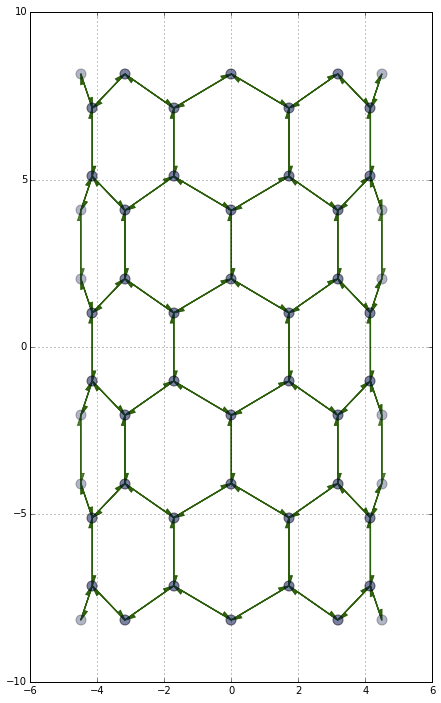

In [57]:
fig, ax = plt_eptm(eptm, ['x', 'z'], edge_arrow_style, points_style)
fig.set_size_inches(10, 12)

In [48]:
from scipy import optimize

In [80]:
def approx_grad(eptm, coords=['x', 'y', 'z']):
    pos0 = eptm.jv_df[coords].values.flatten()
    pos_idx = eptm.jv_idx
    grad = optimize.approx_fprime(pos0,
                                  opt_energy,
                                  1e-9, pos_idx, eptm)
    return grad

(96, 3)

In [81]:
grad_i.shape

(96, 3)

In [66]:
for foo in eptm.jv_df.iterrows():
    print(foo[1]['x'])
    break

4.49580191007


In [93]:
def plot_gradients(eptm, coords, mag=10, ax=None, approx=False, ec='r', fc='r'):
    
    gcoords = ['g'+c for c in coords]
    if approx:
        app_grad = approx_grad(eptm, coords=['x', 'y', 'z'])
        grad_i = pd.DataFrame(index=eptm.jv_idx, 
                              data=app_grad.reshape((-1, 3)),
                              columns=eptm.coords) / eptm.norm_factor
        
    else:    
        grad_i = compute_gradient(eptm, components=False) / eptm.norm_factor
    
    arrows = pd.DataFrame(columns=coords + gcoords,
                          index=eptm.jv_df.index)
    
    arrows[coords] = eptm.jv_df[coords]
    arrows[gcoords] = grad_i[coords] * mag
    
    
    if ax is None:
        fig, ax = plt_eptm(eptm, coords, edge_arrow_style, points_style)
    else:
        fig = ax.get_figure()
    
    for idx, arrow in arrows.iterrows():
        x, y = coords
        gx, gy = gcoords
        ax.arrow(arrow[x], arrow[y], arrow[gx], arrow[gy],
                 ec=ec, fc=fc,
                 width=0.01,
                 alpha=0.5)
        
    return fig, ax

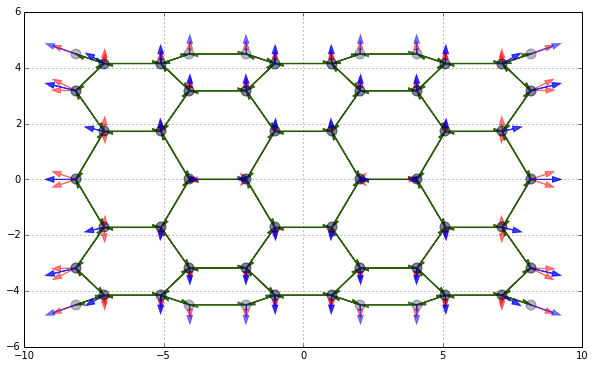

In [94]:
fig, ax = plot_gradients(eptm, ['z', 'y'])
fig, ax = plot_gradients(eptm, ['z', 'y'], ax=ax, approx=True, ec='b', fc='b')

fig.set_size_inches(10, 12)


In [101]:
eptm.je_df.line_tension = eptm.je_df.line_tension * (np.cos(eptm.je_df.nz)**2 + 0.5)

In [102]:
eptm.je_df.head(10)

,,,dy,dx,dz,length,old_jv0,old_jv1,old_cell,line_tension,nx,ny,nz,sub_area
srce,trgt,cell,,,,,,,,,,,,
1,0,0,-1.720469e+00,0.342223,-1.019310,2.028823,56,57,0,3103.524265,1.620200e+00,6.711088e-01,-5.887832e-01,9.249460e-01
2,1,0,-1.458543e+00,0.974567,1.019310,2.028823,57,58,0,4917.974217,7.216450e-16,4.440892e-16,-1.110223e-16,4.272917e-16
0,1,1,1.720469e+00,-0.342223,1.019310,2.028823,56,57,1,4005.297430,3.507383e+00,4.651080e-01,3.925222e-01,1.779897e+00
3,0,1,1.720469e+00,0.342223,-1.019310,2.028823,56,59,1,4005.297430,3.507383e+00,-4.651080e-01,3.925222e-01,1.779897e+00
1,6,1,0.000000e+00,0.000000,2.038621,2.038621,57,62,1,4917.974217,3.507383e+00,2.325540e-01,0.000000e+00,1.757542e+00
4,3,1,0.000000e+00,0.000000,-2.038621,2.038621,59,60,1,4917.974217,3.507383e+00,-2.325540e-01,0.000000e+00,1.757542e+00
5,4,1,-1.720469e+00,-0.342223,-1.019310,2.028823,60,61,1,4005.297430,3.507383e+00,-4.651080e-01,-3.925222e-01,1.779897e+00
6,5,1,-1.720469e+00,0.342223,1.019310,2.028823,61,62,1,4005.297430,3.507383e+00,4.651080e-01,-3.925222e-01,1.779897e+00
5,6,2,1.720469e+00,-0.342223,-1.019310,2.028823,61,62,2,4005.297430,3.418389e+00,9.125138e-01,3.925222e-01,1.779897e+00


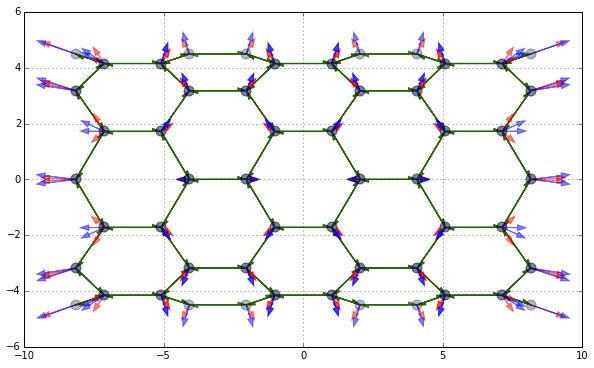

In [103]:
fig, ax = plot_gradients(eptm, ['z', 'y'])
fig, ax = plot_gradients(eptm, ['z', 'y'], ax=ax, approx=True, ec='b', fc='b')

fig.set_size_inches(10, 12)
